# Unsupervised learning for semantic segmentation using Equivariance propreties

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
from metric import *
from utils import * 
from scipy.ndimage.interpolation import rotate as scipy_rotate




## Dataset : Pascal VOC 2012

In [2]:
dataroot = '/data/voc2012'
SAVE_DIR = '/data/model'


In [3]:
def change_type_input(img):
  return img.float()

def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)

def padding(img,pad=(6,9)):
    return transforms.functional.pad(img, pad, fill=0, padding_mode='constant')

size = (513,513)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
transform_input = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])


In [4]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


### Split dataset into a labeled dataset and a unlabeled dataset

In [5]:
class Split_Dataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
percent = 0.3
split = int(len(train_dataset)*percent)
lengths = [split,len(train_dataset)-split]
labeled, unlabeled = random_split(train_dataset, lengths)
train_full_supervised = Split_Dataset(
    labeled)

train_unsupervised = Split_Dataset(
    unlabeled)


### Plot VOC image and mask

In [6]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 513, 513])
torch.Size([513, 513, 3])


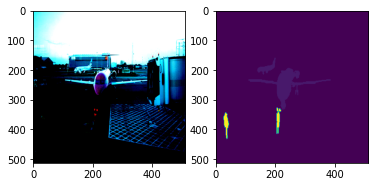

torch.Size([513, 513])

In [7]:
sample = train_dataset.__getitem__(0)
image, mask = sample[0], sample[1]
print(type(image))
print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


### Dataloaders

In [8]:

# Set batch_size
batch_size = 2

dataloader_train_supervised = torch.utils.data.DataLoader(train_full_supervised, batch_size=batch_size,drop_last=True)
dataloader_train_unsupervised = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [9]:
print("Length dataset train fully supervised :",len(train_full_supervised))
print("Length dataset train unsupervised :",len(train_dataset))
print("Length dataset val :",len(val_dataset))

Length dataset train fully supervised : 439
Length dataset train unsupervised : 1464
Length dataset val : 1449


## Test metric code

In [10]:
iou(next(iter(dataloader_val))[1],next(iter(dataloader_train_supervised))[1])

tensor(0.0299)

## Equivarience utils functions

In [11]:
# rotate images
def rotate_image(image,angle,reshape=False):
    """
        Rotate a tensor with a certain angle.
        If true, expands the output image to make it large enough to hold the entire rotated image.
        Else it keeps the same size
    """
    #image = image.squeeze()
    if len(image.size())==3: # Case of a single image.
        axes = ((1,2))
    elif len(image.size())==4: # Case of a batch of images
        axes = ((2,3))
    else:
        print("Size must be 4 or 5.")
        return 
    im = scipy_rotate(image.numpy(),angle=angle,reshape=reshape,axes=axes)
    im_t = torch.FloatTensor(im)
    return (im_t,360-angle)

sample = train_dataset.__getitem__(0)
image, mask = sample[0], sample[1]


In [12]:
def rotate_mask(mask,angle,reshape=False):
    """
        This function take a prediction from the model [batch_size,21,513,513] 
        and rotate, by an angle add as a parameters, the prediction.
        To make sure there is no error it is preferable to use new_angle returned by the function 'rotate_image'.
    """
    with torch.no_grad():
        if len(mask.size())==3: # Case of a single mask.
            axes = ((1,2))
        elif len(mask.size())==4: # Case of a batch of masks
            axes = ((2,3))
        else:
            print("Size must be 4 or 5.")
            return 
        m = scipy_rotate(mask.numpy(),angle=angle,reshape=reshape,axes=axes,mode='nearest')
        mask_t = torch.FloatTensor(m)
        return mask_t

    

### Apply transformations on a batch of images

In [13]:
def compute_transformations_batch(x,model,angle,reshape=False,criterion=nn.KLDivLoss(reduction='mean')):
    x = x.to(device)
    rot_x,new_angle = rotate_image(x.detach().cpu(),angle=angle,reshape=reshape)
    softmax = nn.Softmax(dim=1)
    try:
        pred_x = model(x.to(device))['out'] # a prediction of the original images.
        pred_rot = model(rot_x.to(device))['out'] # a prediction of the rotated images.
    except:
        pred_x = model(x.to(device))
        pred_rot = model(rot_x.to(device))
    
    pred_droit = rotate_mask(pred_rot.detach().cpu(),new_angle,reshape=reshape)
    loss = criterion(softmax(pred_x.cpu()).log(),softmax(pred_droit.cpu()))
    acc = scores(pred_x.argmax(dim=1).detach().cpu(),pred_droit.argmax(dim=1).detach().cpu())["Pixel Accuracy"]
    # compare the pred on the original images and the pred on the rotated images put back in place
    return loss,acc  


## DeepLabV3 Pytorch

In [14]:
def load_model(file=None):
    if file is None:
        model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
        model.to(device)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [15]:
model = load_model() 

## Parameters

In [16]:
learning_rate = 0.02
moment = 0.9
wd = 1e-4
n_epochs = 25
angle_max = 30
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
lr_scheduler_supervised = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train_supervised) * n_epochs)) ** 0.9)
lr_scheduler_unsupervised = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train_unsupervised) * n_epochs)) ** 0.9)

#writer = SummaryWriter()
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
criterion_unsupervised = nn.KLDivLoss(reduction='mean')

## Train unsupervised

In [17]:
save = os.path.join(SAVE_DIR,'deeplabv3_unsupervised_voc.pt')

iou_train_unsup = []
iou_train_sup = []
iou_test = []
loss_train_unsup = []
loss_train_sup = []
loss_test = []
all_loss_train_sup = []
all_loss_train_unsup = []
all_loss_test = []
all_iou_train_sup = []
all_iou_train_unsup = []
all_iou_test = []
pix_accuracy =  []
all_pix_accuracy =  []

In [18]:
for ep in range(n_epochs):
    print("EPOCH",ep)
    for i,(x,mask) in enumerate(dataloader_train_unsupervised):
          x = x.to(device)
          mask = mask.to(device)
          model.train()
          angle = np.random.randint(0,angle_max)
          loss,acc = compute_transformations_batch(x,model,angle,reshape=False,criterion=criterion_unsupervised)
          all_pix_accuracy.append(acc)
          all_loss_train_unsup.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr_scheduler_unsupervised.step()


    m_loss = np.array(all_loss_train_unsup).mean()
    loss_train_unsup.append(m_loss)
    m_acc = np.array(all_pix_accuracy).mean()
    pix_accuracy.append(m_acc)
    try:
        np.save('/data/model/pix_accuracy.npy',pix_accuracy)
    except:
        print('error saving file')
    all_loss_train_unsup = []
    all_pix_accuracy = []
    print("EP:",ep," loss train unsupervised:",m_loss," pixel accuracy between masks ",m_acc)

    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          loss = criterion_supervised(pred,mask)
          all_loss_test.append(loss.item())
          all_iou_test.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))

    m_iou = np.array(all_iou_test).mean()
    m_loss = np.array(all_loss_test).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss_test = []
    all_iou_test = []
    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)

    
    #torch.save(model,save)
    


EPOCH 0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


EP: 0  loss train unsupervised: 0.002032938801532082  pixel accuracy between masks  0.19438029359969752
EP: 0  loss test: 3.207183610324202  iou test: 0.0800550000623254
EPOCH 1
EP: 1  loss train unsupervised: 0.0015226932343660442  pixel accuracy between masks  0.17873472638361765
EP: 1  loss test: 3.1980701124257056  iou test: 0.08392038204225487
EPOCH 2
EP: 2  loss train unsupervised: 0.0012017995448461148  pixel accuracy between masks  0.17630948392010642
EP: 2  loss test: 3.1899902485156884  iou test: 0.08494869647949035
EPOCH 3


/workspace/metric.py:42: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)


EP: 3  loss train unsupervised: 0.0009680423328794203  pixel accuracy between masks  0.1805614707430931
EP: 3  loss test: 3.1862960144569135  iou test: 0.08820878296175265
EPOCH 4
EP: 4  loss train unsupervised: 0.0008034261447362235  pixel accuracy between masks  0.18431745390727025
EP: 4  loss test: 3.1771031323794663  iou test: 0.0889289278365222
EPOCH 5
EP: 5  loss train unsupervised: 0.0006733245650959033  pixel accuracy between masks  0.19046814065976472
EP: 5  loss test: 3.171372799051219  iou test: 0.0922032206670927
EPOCH 6
EP: 6  loss train unsupervised: 0.0005712626258034102  pixel accuracy between masks  0.19993251858542058
EP: 6  loss test: 3.16400906233952  iou test: 0.09273275069410689
EPOCH 7


/workspace/metric.py:44: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


EP: 7  loss train unsupervised: 0.0004955788370482039  pixel accuracy between masks  0.2067571941087037
EP: 7  loss test: 3.1618629623281547  iou test: 0.09471082413697551
EPOCH 8
EP: 8  loss train unsupervised: 0.0004358898808217806  pixel accuracy between masks  0.21289744947080172
EP: 8  loss test: 3.1559280898653226  iou test: 0.09529952517839084
EPOCH 9
EP: 9  loss train unsupervised: 0.00038672832799490156  pixel accuracy between masks  0.22049755962047038
EP: 9  loss test: 3.150454321236446  iou test: 0.09551904223650566
EPOCH 10
EP: 10  loss train unsupervised: 0.00034386382103150794  pixel accuracy between masks  0.23003161425057805
EP: 10  loss test: 3.1483394221601815  iou test: 0.09653605387859239
EPOCH 11
EP: 11  loss train unsupervised: 0.0003103642712566363  pixel accuracy between masks  0.23722637962055051
EP: 11  loss test: 3.1433881897761906  iou test: 0.09690961096427757
EPOCH 12
EP: 12  loss train unsupervised: 0.0002854067367723255  pixel accuracy between masks  0.

## Plot

Text(0, 0.5, 'Mean IOU')

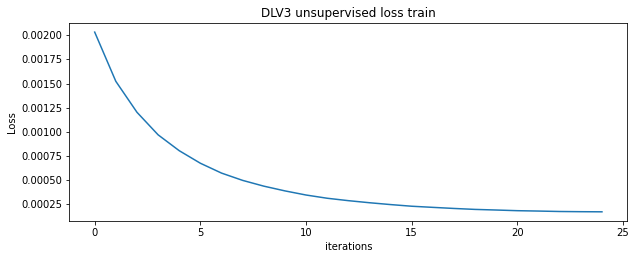

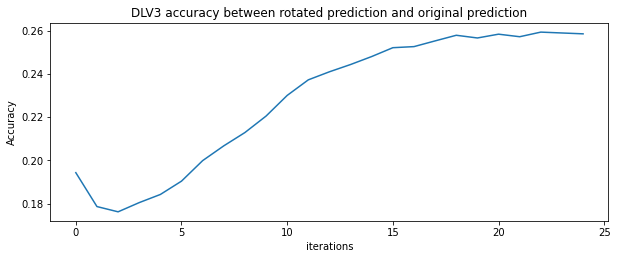

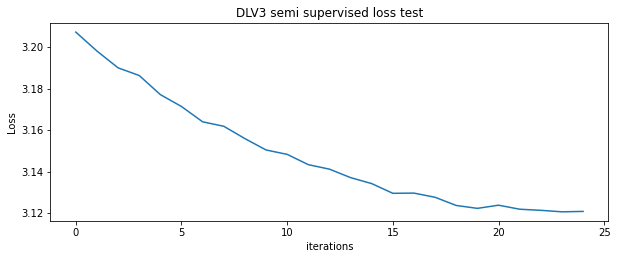

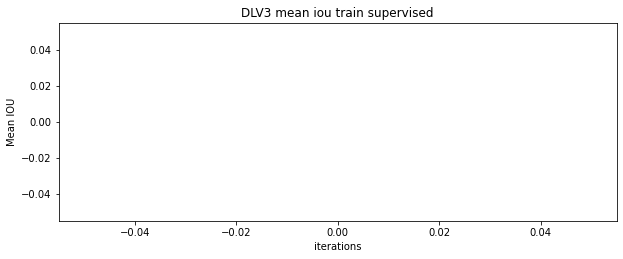

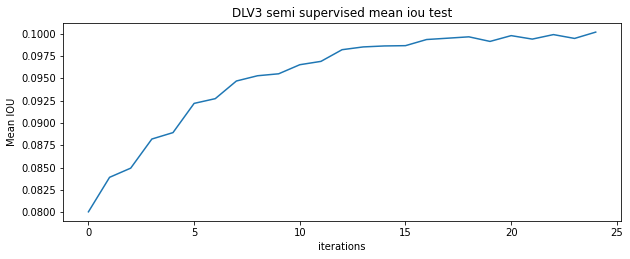

In [19]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 unsupervised loss train")
plt.plot(loss_train_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 accuracy between rotated prediction and original prediction")
plt.plot(pix_accuracy)
plt.xlabel("iterations")
plt.ylabel("Accuracy")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi supervised loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 mean iou train supervised")
plt.plot(iou_train_sup)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi supervised mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [33]:
np.save('/data/model/dlv3_unsup_iou_test.npy',np.array(iou_test))

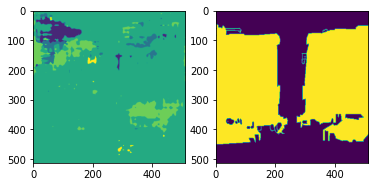

Classe prédite :  ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'cat', 'dog', 'person', 'sheep', 'sofa', 'train']
Classe réelle :  ['background', 'train']
0.0013261440367216503
IOU sur ce masque : 0.011256039142608643


In [38]:
x,mask = next(iter(dataloader_val))
i = 1
x = x.to(device)
mask = mask.to(device)
pred = model(x)
pred = pred["out"]
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))
